In [22]:
import copy
import sys
import os
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from DAST_Network import DAST
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [23]:
class DAST_TF(nn.Module):
    def __init__(self, HP, pretrain_model_path, pretrain_model_name):
        super(DAST_TF, self).__init__()
        self.HP = HP
        self.pretrained_model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        self.pretrained_model.load_state_dict(torch.load(f'{pretrain_model_path}/{pretrain_model_name}.pt'))
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        for param in self.pretrained_model.out_fc.parameters():
            param.requires_grad = True
            
        for param in self.pretrained_model.sensor_enc_input_fc.parameters():
            param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder1.parameters():
        #     param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder2.parameters():
        #     param.requires_grad = True
            
        # for param in self.pretrained_model.sensor_encoder3.parameters():
        #     param.requires_grad = True
            
    def forward(self, x):
        # Forward pass through the pretrained model
        fine_tuned_output = self.pretrained_model(x)
        return fine_tuned_output

In [24]:
class DASTModelTF():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str, pretrain_path: str, pretrain_model_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = '_norm' if is_norm else ''
        self.pretrain_path = pretrain_path
        self.pretrain_model_name = pretrain_model_name
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_2560.npy')
        feature2 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_1280.npy')
        feature3 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_640.npy')
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST_TF(self.HP, self.pretrain_path, self.pretrain_model_name).pretrained_model
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST_TF, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST_TF, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        # self._concate()
        # self._tensorizing()
        # print(self.X_train.shape)
        # model, optimizer, criterion = self._get_model()
        # train_loader, test_loader = self._get_dataloader()
        # times = 0
        # for epoch in range(self.HP['epochs']):
        #     start = time.time()
        #     self.train(model, optimizer, criterion, train_loader, epoch)
        #     end = time.time()
        #     times += end - start
        #     self.eval(model, test_loader, criterion, epoch)
        # print(f"train time: {times/100:.7f}, s/epoch")
        # print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        # print(f"{self.best_train_loss:.7f}")
        # print(f"{self.best_mse_loss:.7f}")
        # print(f"{self.best_rmse_loss:.7f}")
        
    def inference(self, selected_indices, pretrain_model_path, pretrain_model_name, output_path):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        criterion = nn.MSELoss()
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model.load_state_dict(torch.load(f'{pretrain_model_path}/{pretrain_model_name}.pt'))
        model.to(self.device)
        _, test_loader = self._get_dataloader()
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)
        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        print('rmse_loss = ', f'{rmse_loss.item():.7f}',
                'mae_loss = ', f'{mae_loss.item():.7f}',
                'mse_loss = ', f'{test_loss.item():.7f}')
        np.save(f'{output_path}/{pretrain_model_name}_{self.TEST_DATASETS[0]}.npy', out_batch_pre)

In [25]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
PRETRAIN_DATASET = 'Bearing2'
FINETUNE_DATASET = 'Bearing3'
# TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
# TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
# TRAIN_DATASETS = ['Bearing2_1', 'Bearing2_2']
# TEST_DATASET = ['Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7']
TRAIN_DATASETS = ['Bearing3_1', 'Bearing3_2']
# TEST_DATASET = ['Bearing3_3']

TEST_DATASET = ['Bearing3_3']
MODEL_SAVE_PATH = '../../../model'
MODEL_SAVE_NAME = f'{PRETRAIN_DATASET}_pretrain_{FINETUNE_DATASET}_finetune_7'
PRETRAIN_MODEL_PATH = '../../../model'
PRETRAIN_MODEL_NAME = f'{PRETRAIN_DATASET}_pretrain_7'
IS_NORM = False

In [26]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 10
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [27]:
dast_model = DASTModelTF(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME, pretrain_path=PRETRAIN_MODEL_PATH, pretrain_model_name=PRETRAIN_MODEL_NAME)

In [28]:
PRETRAIN_MODEL_PATH = '../../../model'
PRETRAIN_DATASET = 'Bearing1'
FINETUNE_DATASET = 'Bearing3'
PRETRAIN_MODEL_NAME = f'{PRETRAIN_DATASET}_pretrain_{FINETUNE_DATASET}_finetune_7'
NP_OUTPUT = '../../../data/np/'
dast_model.inference(selected_indices, PRETRAIN_MODEL_PATH, PRETRAIN_MODEL_NAME, NP_OUTPUT)

rmse_loss =  0.0639432 mae_loss =  0.0388348 mse_loss =  0.0040887


In [7]:
dast_model.main(selected_indices)

torch.Size([2072, 40, 49])


100%|██████████| 9/9 [00:00<00:00, 21.36it/s]


epoch =  0 train_loss =  0.05056210613757786
rmse_loss =  0.1585375964641571 mae_loss =  0.13550233840942383 mse_loss =  0.025134170427918434


100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


epoch =  1 train_loss =  0.06086817021585173
rmse_loss =  0.1475905030965805 mae_loss =  0.08957698941230774 mse_loss =  0.021782957017421722


100%|██████████| 9/9 [00:00<00:00, 21.23it/s]


epoch =  2 train_loss =  0.03828665347666376
rmse_loss =  0.11705488711595535 mae_loss =  0.08685991913080215 mse_loss =  0.0137018458917737


100%|██████████| 9/9 [00:00<00:00, 21.65it/s]


epoch =  3 train_loss =  0.04424209649571114
rmse_loss =  0.12246531248092651 mae_loss =  0.06857683509588242 mse_loss =  0.0149977533146739


100%|██████████| 9/9 [00:00<00:00, 22.56it/s]


epoch =  4 train_loss =  0.03966497673860027
rmse_loss =  0.11897678673267365 mae_loss =  0.07608410716056824 mse_loss =  0.014155476354062557


100%|██████████| 9/9 [00:00<00:00, 22.94it/s]


epoch =  5 train_loss =  0.040406654226697154
rmse_loss =  0.11708009988069534 mae_loss =  0.06994123011827469 mse_loss =  0.013707750476896763


100%|██████████| 9/9 [00:00<00:00, 22.09it/s]


epoch =  6 train_loss =  0.03969963107051121
rmse_loss =  0.11234039068222046 mae_loss =  0.06692242622375488 mse_loss =  0.012620363384485245


100%|██████████| 9/9 [00:00<00:00, 36.67it/s]


epoch =  7 train_loss =  0.03877553545559446
rmse_loss =  0.10927388817071915 mae_loss =  0.06509537249803543 mse_loss =  0.011940782889723778


100%|██████████| 9/9 [00:00<00:00, 38.26it/s]


epoch =  8 train_loss =  0.03897069764530493
rmse_loss =  0.10807878524065018 mae_loss =  0.06246788427233696 mse_loss =  0.011681023053824902


100%|██████████| 9/9 [00:00<00:00, 39.37it/s]


epoch =  9 train_loss =  0.03807399346907106
rmse_loss =  0.10624626278877258 mae_loss =  0.06187954545021057 mse_loss =  0.011288268491625786


100%|██████████| 9/9 [00:00<00:00, 39.09it/s]


epoch =  10 train_loss =  0.038141212322645716
rmse_loss =  0.1050286814570427 mae_loss =  0.05954020097851753 mse_loss =  0.011031024158000946


100%|██████████| 9/9 [00:00<00:00, 39.28it/s]


epoch =  11 train_loss =  0.03748199255723092
rmse_loss =  0.10314071923494339 mae_loss =  0.05839826539158821 mse_loss =  0.010638007894158363


100%|██████████| 9/9 [00:00<00:00, 39.25it/s]


epoch =  12 train_loss =  0.03733179366423024
rmse_loss =  0.10198703408241272 mae_loss =  0.056737110018730164 mse_loss =  0.010401355102658272


100%|██████████| 9/9 [00:00<00:00, 39.18it/s]


epoch =  13 train_loss =  0.0369242614445587
rmse_loss =  0.10081896930932999 mae_loss =  0.055702704936265945 mse_loss =  0.010164463892579079


100%|██████████| 9/9 [00:00<00:00, 32.54it/s]


epoch =  14 train_loss =  0.036688716513001256
rmse_loss =  0.09993649274110794 mae_loss =  0.05459754541516304 mse_loss =  0.00998730305582285


100%|██████████| 9/9 [00:00<00:00, 39.25it/s]


epoch =  15 train_loss =  0.03638467200410863
rmse_loss =  0.09900656342506409 mae_loss =  0.053639043122529984 mse_loss =  0.009802299551665783


100%|██████████| 9/9 [00:00<00:00, 38.95it/s]


epoch =  16 train_loss =  0.036115639170424804
rmse_loss =  0.0981813594698906 mae_loss =  0.05272381380200386 mse_loss =  0.009639578871428967


100%|██████████| 9/9 [00:00<00:00, 39.16it/s]


epoch =  17 train_loss =  0.03586729665079878
rmse_loss =  0.09756183624267578 mae_loss =  0.05195682495832443 mse_loss =  0.009518311358988285


100%|██████████| 9/9 [00:00<00:00, 21.80it/s]


epoch =  18 train_loss =  0.03561793319467041
rmse_loss =  0.09698324650526047 mae_loss =  0.051277268677949905 mse_loss =  0.009405749849975109


100%|██████████| 9/9 [00:00<00:00, 21.82it/s]


epoch =  19 train_loss =  0.03538149196861519
rmse_loss =  0.09651417285203934 mae_loss =  0.050739724189043045 mse_loss =  0.009314985014498234


100%|██████████| 9/9 [00:00<00:00, 20.99it/s]


epoch =  20 train_loss =  0.035174097426028714
rmse_loss =  0.09629117697477341 mae_loss =  0.05030696094036102 mse_loss =  0.00927199050784111


100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


epoch =  21 train_loss =  0.034958449761486717
rmse_loss =  0.09598159790039062 mae_loss =  0.04989023879170418 mse_loss =  0.009212466888129711


100%|██████████| 9/9 [00:00<00:00, 20.46it/s]


epoch =  22 train_loss =  0.034734366849685706
rmse_loss =  0.09573313593864441 mae_loss =  0.04954491928219795 mse_loss =  0.009164833463728428


100%|██████████| 9/9 [00:00<00:00, 21.16it/s]


epoch =  23 train_loss =  0.0345354674435738
rmse_loss =  0.09562460333108902 mae_loss =  0.049280814826488495 mse_loss =  0.009144064970314503


100%|██████████| 9/9 [00:00<00:00, 23.08it/s]


epoch =  24 train_loss =  0.03434265071215729
rmse_loss =  0.09559324383735657 mae_loss =  0.0490989163517952 mse_loss =  0.009138068184256554


100%|██████████| 9/9 [00:00<00:00, 22.01it/s]


epoch =  25 train_loss =  0.0341584654007521
rmse_loss =  0.09561070799827576 mae_loss =  0.04897607862949371 mse_loss =  0.009141407907009125


100%|██████████| 9/9 [00:00<00:00, 23.40it/s]


epoch =  26 train_loss =  0.03397842517329587
rmse_loss =  0.0956764817237854 mae_loss =  0.048903126269578934 mse_loss =  0.009153989143669605


100%|██████████| 9/9 [00:00<00:00, 23.79it/s]


epoch =  27 train_loss =  0.03379944246262312
rmse_loss =  0.09580383449792862 mae_loss =  0.0489150770008564 mse_loss =  0.009178374893963337


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


epoch =  28 train_loss =  0.03363316757087079
rmse_loss =  0.09600480645895004 mae_loss =  0.049003735184669495 mse_loss =  0.009216923266649246


100%|██████████| 9/9 [00:00<00:00, 22.94it/s]


epoch =  29 train_loss =  0.03346932617326578
rmse_loss =  0.09624771773815155 mae_loss =  0.04911990463733673 mse_loss =  0.00926362257450819


100%|██████████| 9/9 [00:00<00:00, 24.02it/s]


epoch =  30 train_loss =  0.03330774279311299
rmse_loss =  0.09652978926897049 mae_loss =  0.04927130788564682 mse_loss =  0.009318000636994839


100%|██████████| 9/9 [00:00<00:00, 23.23it/s]


epoch =  31 train_loss =  0.03315387412698732
rmse_loss =  0.09686220437288284 mae_loss =  0.04947102814912796 mse_loss =  0.009382287040352821


100%|██████████| 9/9 [00:00<00:00, 21.98it/s]


epoch =  32 train_loss =  0.03299971188729008
rmse_loss =  0.09722717106342316 mae_loss =  0.049698133021593094 mse_loss =  0.009453123435378075


100%|██████████| 9/9 [00:00<00:00, 23.12it/s]


epoch =  33 train_loss =  0.03285307351810237
rmse_loss =  0.09763920307159424 mae_loss =  0.04996357858181 mse_loss =  0.009533414617180824


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


epoch =  34 train_loss =  0.032706361160510115
rmse_loss =  0.09807804226875305 mae_loss =  0.05025940015912056 mse_loss =  0.009619302116334438


100%|██████████| 9/9 [00:00<00:00, 22.80it/s]


epoch =  35 train_loss =  0.03256648421908418
rmse_loss =  0.0985594242811203 mae_loss =  0.050591759383678436 mse_loss =  0.009713960811495781


100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


epoch =  36 train_loss =  0.03242557845078409
rmse_loss =  0.0990607962012291 mae_loss =  0.05092994496226311 mse_loss =  0.009813041426241398


100%|██████████| 9/9 [00:00<00:00, 23.42it/s]


epoch =  37 train_loss =  0.03229315441826151
rmse_loss =  0.09960512816905975 mae_loss =  0.05130463466048241 mse_loss =  0.009921181946992874


100%|██████████| 9/9 [00:00<00:00, 24.70it/s]


epoch =  38 train_loss =  0.03215748669269184
rmse_loss =  0.10016070306301117 mae_loss =  0.05169666185975075 mse_loss =  0.010032165795564651


100%|██████████| 9/9 [00:00<00:00, 23.09it/s]


epoch =  39 train_loss =  0.03203113822059499
rmse_loss =  0.10075639933347702 mae_loss =  0.052128974348306656 mse_loss =  0.010151851922273636


100%|██████████| 9/9 [00:00<00:00, 24.13it/s]


epoch =  40 train_loss =  0.031902024160242744
rmse_loss =  0.10136079788208008 mae_loss =  0.052566204220056534 mse_loss =  0.010274010710418224


100%|██████████| 9/9 [00:00<00:00, 23.42it/s]


epoch =  41 train_loss =  0.031778205988100834
rmse_loss =  0.10199300944805145 mae_loss =  0.05303744599223137 mse_loss =  0.010402573272585869


100%|██████████| 9/9 [00:00<00:00, 24.21it/s]


epoch =  42 train_loss =  0.031655580503866076
rmse_loss =  0.10264131426811218 mae_loss =  0.05351666733622551 mse_loss =  0.01053523924201727


100%|██████████| 9/9 [00:00<00:00, 23.45it/s]


epoch =  43 train_loss =  0.03153464073936144
rmse_loss =  0.10330560058355331 mae_loss =  0.05400524660944939 mse_loss =  0.010672047734260559


100%|██████████| 9/9 [00:00<00:00, 22.73it/s]


epoch =  44 train_loss =  0.03141585362350775
rmse_loss =  0.10398390144109726 mae_loss =  0.054500337690114975 mse_loss =  0.010812651365995407


100%|██████████| 9/9 [00:00<00:00, 21.63it/s]


epoch =  45 train_loss =  0.03129853427203165
rmse_loss =  0.10467711091041565 mae_loss =  0.055001065135002136 mse_loss =  0.010957296937704086


100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


epoch =  46 train_loss =  0.03118168466931416
rmse_loss =  0.10538914799690247 mae_loss =  0.05551037937402725 mse_loss =  0.011106871999800205


100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


epoch =  47 train_loss =  0.03106375281802482
rmse_loss =  0.10611054301261902 mae_loss =  0.05602075904607773 mse_loss =  0.011259447783231735


100%|██████████| 9/9 [00:00<00:00, 21.70it/s]


epoch =  48 train_loss =  0.030946115316409204
rmse_loss =  0.10684549808502197 mae_loss =  0.056539297103881836 mse_loss =  0.01141596119850874


100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


epoch =  49 train_loss =  0.03083051389290227
rmse_loss =  0.10759768635034561 mae_loss =  0.0570683516561985 mse_loss =  0.011577261611819267


100%|██████████| 9/9 [00:00<00:00, 20.75it/s]


epoch =  50 train_loss =  0.030717358510527346
rmse_loss =  0.10836726427078247 mae_loss =  0.057618118822574615 mse_loss =  0.011743464507162571


100%|██████████| 9/9 [00:00<00:00, 23.48it/s]


epoch =  51 train_loss =  0.0306043045129627
rmse_loss =  0.109142005443573 mae_loss =  0.05817384645342827 mse_loss =  0.011911977082490921


100%|██████████| 9/9 [00:00<00:00, 23.35it/s]


epoch =  52 train_loss =  0.030494199781161215
rmse_loss =  0.10992713272571564 mae_loss =  0.0587344691157341 mse_loss =  0.012083973735570908


100%|██████████| 9/9 [00:00<00:00, 21.29it/s]


epoch =  53 train_loss =  0.030384738877829578
rmse_loss =  0.11071769148111343 mae_loss =  0.05929560959339142 mse_loss =  0.012258407659828663


100%|██████████| 9/9 [00:00<00:00, 22.35it/s]


epoch =  54 train_loss =  0.030275502656069066
rmse_loss =  0.1115160807967186 mae_loss =  0.0598629005253315 mse_loss =  0.012435835786163807


100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


epoch =  55 train_loss =  0.030166045400417514
rmse_loss =  0.11231184750795364 mae_loss =  0.06042208895087242 mse_loss =  0.012613950297236443


100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


epoch =  56 train_loss =  0.030058739008381963
rmse_loss =  0.11310601979494095 mae_loss =  0.06097793951630592 mse_loss =  0.012792970985174179


100%|██████████| 9/9 [00:00<00:00, 20.45it/s]


epoch =  57 train_loss =  0.029954024228370853
rmse_loss =  0.1139037013053894 mae_loss =  0.06152551993727684 mse_loss =  0.012974053621292114


100%|██████████| 9/9 [00:00<00:00, 22.79it/s]


epoch =  58 train_loss =  0.0298526709795826
rmse_loss =  0.1146787777543068 mae_loss =  0.06206892058253288 mse_loss =  0.01315122190862894


100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


epoch =  59 train_loss =  0.029754560699479446
rmse_loss =  0.1155100092291832 mae_loss =  0.06264527142047882 mse_loss =  0.01334256213158369


100%|██████████| 9/9 [00:00<00:00, 20.62it/s]


epoch =  60 train_loss =  0.02964749184644057
rmse_loss =  0.11626265943050385 mae_loss =  0.06318365037441254 mse_loss =  0.013517005369067192


100%|██████████| 9/9 [00:00<00:00, 21.75it/s]


epoch =  61 train_loss =  0.029549819003376696
rmse_loss =  0.11710390448570251 mae_loss =  0.06375893205404282 mse_loss =  0.013713324442505836


100%|██████████| 9/9 [00:00<00:00, 20.41it/s]


epoch =  62 train_loss =  0.02944357765631543
rmse_loss =  0.11788129806518555 mae_loss =  0.06428732722997665 mse_loss =  0.013895999640226364


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


epoch =  63 train_loss =  0.029346371121290658
rmse_loss =  0.11868132650852203 mae_loss =  0.06483414769172668 mse_loss =  0.0140852564945817


100%|██████████| 9/9 [00:00<00:00, 20.67it/s]


epoch =  64 train_loss =  0.02925361729123526
rmse_loss =  0.11950863897800446 mae_loss =  0.06539496034383774 mse_loss =  0.014282315038144588


100%|██████████| 9/9 [00:00<00:00, 22.89it/s]


epoch =  65 train_loss =  0.029153218648085993
rmse_loss =  0.12028247863054276 mae_loss =  0.06591038405895233 mse_loss =  0.0144678745418787


100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


epoch =  66 train_loss =  0.029065394411898322
rmse_loss =  0.12109281867742538 mae_loss =  0.06647898256778717 mse_loss =  0.014663469977676868


100%|██████████| 9/9 [00:00<00:00, 21.59it/s]


epoch =  67 train_loss =  0.028967230244436197
rmse_loss =  0.12184715270996094 mae_loss =  0.0669892430305481 mse_loss =  0.01484672911465168


100%|██████████| 9/9 [00:00<00:00, 22.63it/s]


epoch =  68 train_loss =  0.02887792269595795
rmse_loss =  0.12263666093349457 mae_loss =  0.06753671169281006 mse_loss =  0.015039751306176186


100%|██████████| 9/9 [00:00<00:00, 21.57it/s]


epoch =  69 train_loss =  0.028784802959611017
rmse_loss =  0.12340882420539856 mae_loss =  0.06805723160505295 mse_loss =  0.015229737386107445


100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


epoch =  70 train_loss =  0.02869620813160307
rmse_loss =  0.12420234829187393 mae_loss =  0.06860847026109695 mse_loss =  0.015426223166286945


100%|██████████| 9/9 [00:00<00:00, 24.16it/s]


epoch =  71 train_loss =  0.028605708619579673
rmse_loss =  0.1249714195728302 mae_loss =  0.06914210319519043 mse_loss =  0.015617855824530125


100%|██████████| 9/9 [00:00<00:00, 22.02it/s]


epoch =  72 train_loss =  0.02851864910270605
rmse_loss =  0.1257524937391281 mae_loss =  0.0697011649608612 mse_loss =  0.015813691541552544


100%|██████████| 9/9 [00:00<00:00, 22.80it/s]


epoch =  73 train_loss =  0.02842780373369654
rmse_loss =  0.1265135407447815 mae_loss =  0.07022915780544281 mse_loss =  0.01600567437708378


100%|██████████| 9/9 [00:00<00:00, 22.78it/s]


epoch =  74 train_loss =  0.028343717101961374
rmse_loss =  0.12732119858264923 mae_loss =  0.07080865651369095 mse_loss =  0.016210688278079033


100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


epoch =  75 train_loss =  0.028252908520193562
rmse_loss =  0.12808963656425476 mae_loss =  0.0713343620300293 mse_loss =  0.0164069551974535


100%|██████████| 9/9 [00:00<00:00, 22.86it/s]


epoch =  76 train_loss =  0.02817246923223138
rmse_loss =  0.12890994548797607 mae_loss =  0.07193402200937271 mse_loss =  0.016617773100733757


100%|██████████| 9/9 [00:00<00:00, 23.75it/s]


epoch =  77 train_loss =  0.028080999851226807
rmse_loss =  0.1296544075012207 mae_loss =  0.07244101166725159 mse_loss =  0.016810264438390732


100%|██████████| 9/9 [00:00<00:00, 20.81it/s]


epoch =  78 train_loss =  0.02800633018422458
rmse_loss =  0.130472794175148 mae_loss =  0.07306334376335144 mse_loss =  0.017023151740431786


100%|██████████| 9/9 [00:00<00:00, 21.44it/s]


epoch =  79 train_loss =  0.027913462086063292
rmse_loss =  0.13117937743663788 mae_loss =  0.0735478401184082 mse_loss =  0.017208028584718704


100%|██████████| 9/9 [00:00<00:00, 22.71it/s]


epoch =  80 train_loss =  0.02784048155364063
rmse_loss =  0.13197897374629974 mae_loss =  0.07416840642690659 mse_loss =  0.017418447881937027


100%|██████████| 9/9 [00:00<00:00, 22.93it/s]


epoch =  81 train_loss =  0.027748421610643465
rmse_loss =  0.13266773521900177 mae_loss =  0.0746501237154007 mse_loss =  0.017600728198885918


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


epoch =  82 train_loss =  0.02767306356690824
rmse_loss =  0.13343065977096558 mae_loss =  0.07525008171796799 mse_loss =  0.01780373975634575


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


epoch =  83 train_loss =  0.027585009552745357
rmse_loss =  0.13410474359989166 mae_loss =  0.07577032595872879 mse_loss =  0.01798408292233944


100%|██████████| 9/9 [00:00<00:00, 22.88it/s]


epoch =  84 train_loss =  0.027504536814780697
rmse_loss =  0.1348034292459488 mae_loss =  0.07634436339139938 mse_loss =  0.018171966075897217


100%|██████████| 9/9 [00:00<00:00, 24.49it/s]


epoch =  85 train_loss =  0.027419438171717856
rmse_loss =  0.13549014925956726 mae_loss =  0.07690636068582535 mse_loss =  0.01835757866501808


100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


epoch =  86 train_loss =  0.02733065327629447
rmse_loss =  0.13619904220104218 mae_loss =  0.07745536416769028 mse_loss =  0.01855017989873886


100%|██████████| 9/9 [00:00<00:00, 23.80it/s]


epoch =  87 train_loss =  0.027246453980397847
rmse_loss =  0.13695600628852844 mae_loss =  0.07802614569664001 mse_loss =  0.018756946548819542


100%|██████████| 9/9 [00:00<00:00, 23.58it/s]


epoch =  88 train_loss =  0.027163052776207525
rmse_loss =  0.13770410418510437 mae_loss =  0.07859238982200623 mse_loss =  0.018962418660521507


100%|██████████| 9/9 [00:00<00:00, 22.80it/s]


epoch =  89 train_loss =  0.027080759380219713
rmse_loss =  0.1384384036064148 mae_loss =  0.07915898412466049 mse_loss =  0.019165191799402237


100%|██████████| 9/9 [00:00<00:00, 23.28it/s]


epoch =  90 train_loss =  0.026999152213748958
rmse_loss =  0.1391739845275879 mae_loss =  0.07973645627498627 mse_loss =  0.019369397312402725


100%|██████████| 9/9 [00:00<00:00, 23.52it/s]


epoch =  91 train_loss =  0.026919149431503482
rmse_loss =  0.1399257928133011 mae_loss =  0.08032716810703278 mse_loss =  0.019579226151108742


100%|██████████| 9/9 [00:00<00:00, 23.58it/s]


epoch =  92 train_loss =  0.026840404762576025
rmse_loss =  0.14068901538848877 mae_loss =  0.08092296123504639 mse_loss =  0.019793398678302765


100%|██████████| 9/9 [00:00<00:00, 23.41it/s]


epoch =  93 train_loss =  0.026761737108851474
rmse_loss =  0.14145256578922272 mae_loss =  0.08151416480541229 mse_loss =  0.02000882849097252


100%|██████████| 9/9 [00:00<00:00, 22.22it/s]


epoch =  94 train_loss =  0.026683508496110637
rmse_loss =  0.14221785962581635 mae_loss =  0.08210724592208862 mse_loss =  0.020225917920470238


100%|██████████| 9/9 [00:00<00:00, 23.75it/s]


epoch =  95 train_loss =  0.026605758893614013
rmse_loss =  0.14298592507839203 mae_loss =  0.08270102739334106 mse_loss =  0.020444974303245544


100%|██████████| 9/9 [00:00<00:00, 24.89it/s]


epoch =  96 train_loss =  0.02652857548350261
rmse_loss =  0.14375637471675873 mae_loss =  0.08329863101243973 mse_loss =  0.02066589519381523


100%|██████████| 9/9 [00:00<00:00, 23.66it/s]


epoch =  97 train_loss =  0.02645123993150062
rmse_loss =  0.1445237249135971 mae_loss =  0.08389592170715332 mse_loss =  0.020887106657028198


100%|██████████| 9/9 [00:00<00:00, 22.93it/s]


epoch =  98 train_loss =  0.02637414742882053
rmse_loss =  0.14529287815093994 mae_loss =  0.08449169248342514 mse_loss =  0.02111002244055271


100%|██████████| 9/9 [00:00<00:00, 23.51it/s]

epoch =  99 train_loss =  0.02629795957667132
rmse_loss =  0.1460718959569931 mae_loss =  0.08509918302297592 mse_loss =  0.0213369969278574
train time: 0.3857983, s/epoch
embed1: 20, embed2: 10, lr: 0.001, dec_seq_len: 6
0.0262980
0.0091381
0.0955932


In [8]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

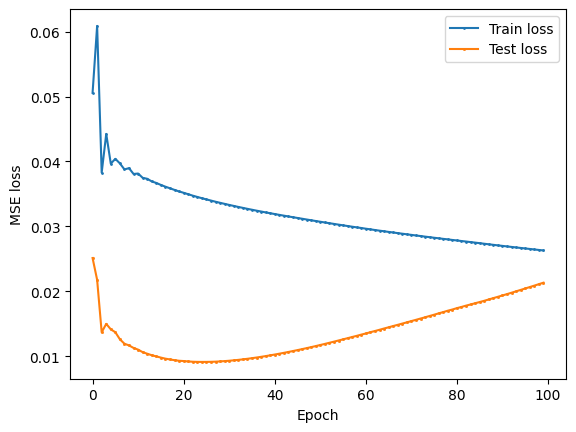

In [9]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

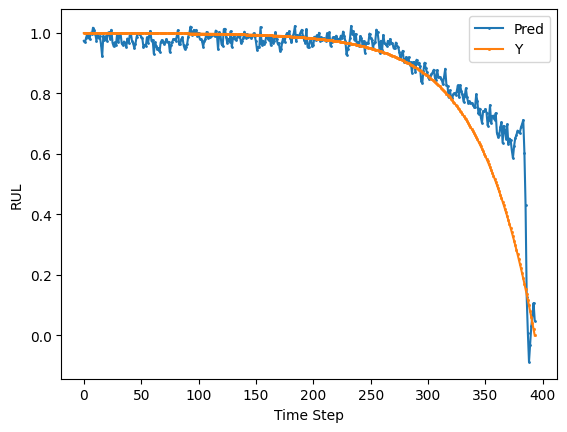

In [10]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

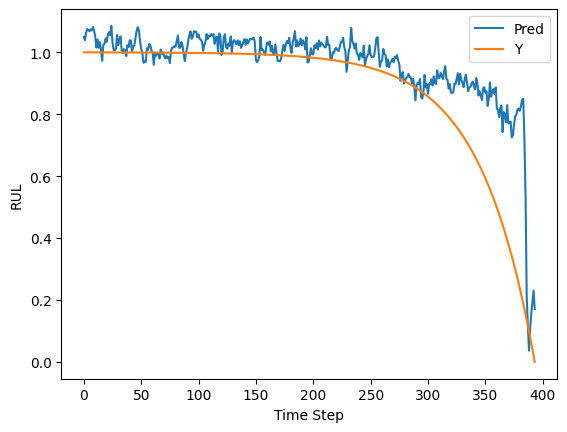

In [16]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=0.01)
    plt.plot(y, label='Y', marker='s', markersize=0.01)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [12]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")


0.0262980
0.0091381
0.0955932


In [13]:
# run above